In [944]:
# IMPORT REQUIRED LIBRARIES
import numpy as np
import osmnx as ox
import networkx as nx
import itertools
from random import choice
import math
import time

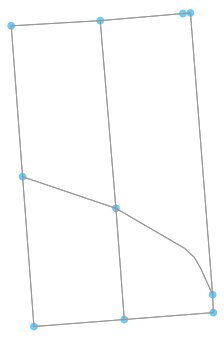


 n (number of nodes in the graph): 10

 m (number of edges in the graph): 13.0

 street_length_total (sum in meters): 710.483


In [899]:
# BUILD GRAPH & GET STATS

# set bbox bounds: (will eventually come from drawing)

north = 37.7599 # max lat 
south = 37.7569 # min lat
east = -122.3997 # max lng
west = -122.4023 # min lng 
 
# create graph
G = ox.graph_from_bbox(north, south, east, west, network_type='walk')

# display graph
ox.plot_graph(G, node_size=60)

# Get graph info 
basic_stats = ox.basic_stats(G)
    
print("\n n (number of nodes in the graph):", basic_stats['n'])
print("\n m (number of edges in the graph):", basic_stats['m']/2) # because it's an undirected graph
print("\n street_length_total (sum in meters):", basic_stats['street_length_total']/2)


In [900]:
# GET graph data frames
nodes, edges = ox.graph_to_gdfs(G) # make two dataframes - one for nodes and one for edges

# SHOW EDGES DATAFRAME
# edges

# EDGES REF:
    # geometry
    # highway tag
    # length (meters)
    # name
    # osmid - of the way that the edge is part of, not just of the section
    # u - start node
    # v - end node 

In [901]:
# SHOW NODES DATAFRAME
# nodes

# NODES REF
    # osmid 
    # x
    # y 
    # geometry: full geometry (including geometry type, all are POINT)

In [1224]:
# FIND ODD NODES

def make_nodes_dict(graph):
    """ Given a graph, make dict where:
            key is each node,  
            value is set of all edges that contain node.
    """
    
    # initialized an empty dict for nodes
    nodes_dict = {}

    # loop over graph's node object
    for node in graph.nodes:
        # make a key for the node 
        # initialize the key's valuse as a set, so that only one "version"
        # of each edge can be added -- context: osmnx makes a directed 
        # graph so edge (A,B) is distinct from (B,A). We want these edges to be
        # considered identical. Thus, we use a set. 
       
        nodes_dict[node] = set() 
        
    # Confirm that the dict has the expected number of nodes 
    expected_node_count = basic_stats['n']
    actual_node_count = len(nodes_dict.keys())
    # print("Confirmed node count:", expected_node_count == actual_node_count)

     
    if expected_node_count == actual_node_count:
        # If the node count matches expectation, move on to add edges to set.
        
        # WIP - check edge count: 
            # Expected edge count is half of what's 
            # reported from basic_stats because we are using an undirected graph.
            # expected_edge_count = basic_stats['m'] 
            # edge_counter = 0

        # loop over each edge in graph's edge object, see which edges contain current node
        for edge in G.edges:

            # Note: each edge is a three item tuple: (start,end,weight) 
            # the stored weight in the edge is defaulted to 0 and 
            # is superfluous, so it will be ignored moving forward

            start_node = edge[0]
            end_node = edge[1]

            # name edge by start and end node 
            edge_identifier = (start_node, end_node)
            
            # add edge tuple to the node's value set 
            # NOTE: not naming edge by wayid because osm wayids are not unique to a particular edge
            # in osm a 'way' often contains several edges
            
            nodes_dict[start_node].add(edge_identifier)

        return nodes_dict
    else:
        print("ERROR: node count in dict != node count from graph. Figure that out!")
        return None
    
# print("\nNodes dict:\n")
# print(make_nodes_dict(G))

# nodes_dict = make_nodes_dict(G)

In [903]:
# GET ODD NODES 

# NOTE: odd node = node that has an odd count of associated edges


def get_odd_nodes(graph):
    
    """Take in a graph, return list of nodes with odd order."""
    
    # initialize empy list for odd nodes
    odd_nodes = []

    # get dict of nodes and associated edges from make_nodes_dict function
    nodes_dict = make_nodes_dict(graph) 

    # loop over nodes (keys) in ndoes dict 
    for node in nodes_dict:

        # get the count of edges (length of edges set) for the current node
        all_edges = nodes_dict[node]
        edge_count = len(all_edges)

        
        if edge_count % 2 != 0:
            # if the edge count is odd, add node to the odd_nodes list
            odd_nodes.append(node)

    return odd_nodes        

# print("\nOdd nodes:")
# print(get_odd_nodes(G))

# odd_nodes = get_odd_nodes(G)




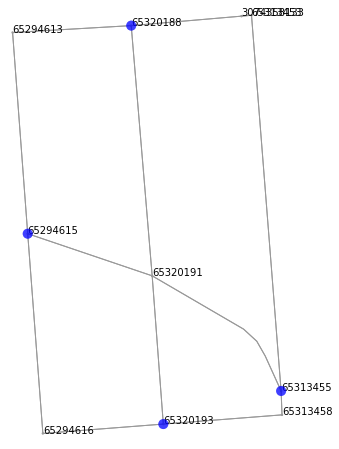

In [904]:
# Display graph for visual check of odd nodes

def get_odd_nodes_visual(odd_nodes_list, graph):
    """
    Given a graph and a list of odd nodes, 
    display the graph with odd nodes visualized."""

    odd_nodes_hacky_routes = []

    for node in odd_nodes_list:

        # get a "route" for each node to itself, so can be plotted
        route = nx.shortest_path(graph, node, node, weight='length')

        odd_nodes_hacky_routes.append(route)

    # ubpack to layer graph and extra stuff on top
    fig, ax = ox.plot_graph_routes(graph, 
                                   odd_nodes_hacky_routes, 
                                   # make route color white to mask it visually
                                   route_color='w',
                                   orig_dest_node_color='b', 
                                   node_size=6,
                                   annotate=True,
                                   # make the figure a bit bigger than default
                                   fig_height=8
                                  )

get_odd_nodes_visual(odd_nodes, G)

In [905]:
# GET POSSIBLE COMBINATIONS OF ODD NODES

alpha_list = ['A','B','C','D']



# VERBOSE VARS VERSION

def all_pairs(lst):
    
    """ 
    Takes a list of items, returns a generator which (I think)
    contains lists which are each a way to create pairs from
    the input list.
    
    THIS FUNCTION IS NOT MINE: it is from: 
    https://stackoverflow.com/questions/5360220/how-to-split-a-list-into-pairs-in-all-possible-ways
    
    !! I need to work more on this to refactor (see 'list_of_pairs' notebook)
    """
    
    if len(lst) < 2:
        
        # if there are zero items or just one 
        # return (yield?) an empty list
        # basically used exclusively for when you get to the
        # last item in the input list so no more pairs can be made
        # confirm ^^
        
        yield []
        return
    
    if len(lst) % 2 == 1:
        # Handle odd length list
        for i in range(len(lst)):
            
            # items from 0 to i 
            items_to_left_ = lst[:i]    

            # items right of i to end of list
            items_to_right_ = lst[i+1:]
            
            for result in all_pairs(items_to_left_ + items_to_right_):
                yield result
    else:
        cur_first_item = lst[0]
        
        for i in range(1,len(lst)):
            
            next_item = lst[i]
            
            pair = (cur_first_item, next_item)
            
            items_to_left_of_pair = lst[1:i]
            items_to_right_of_pair = lst[i+1:]
            
            for rest in all_pairs(items_to_left_of_pair + items_to_right_of_pair):
                yield [pair] + rest

def get_list_of_all_pairs_lists(lst):
    
    list_of_possible_pairs_lists = []
    
    all_pairs_object = all_pairs(lst)
    
    for pairs_list in all_pairs_object: 
        list_of_possible_pairs_lists.append(pairs_list)
    
    return list_of_possible_pairs_lists
    


In [906]:
# SCRAPPY TESTING OF POSSIBLE PAIRINGS FUNCTIONS

# possible_pairings_list = get_list_of_all_pairs_lists(alpha_list)

# possible_pairings_list = get_list_of_all_pairs_lists(odd_nodes)

# print("List of possible pairings lists:\n")
# print(list(possible_pairings_list))

# print("\n\nPossible pairings lists:")
# for pair_list in possible_pairings_list:
#     print()
#     print("  ",pair_list)
    

# expected output for lightning talk example
expected_output = [[(65294615, 65320193), (65313455, 65320188)], [(65294615, 65313455), (65320193, 65320188)], [(65294615, 65320188), (65320193, 65313455)]]
  
# scrappy test  
print("\nSCRAPPY TEST:")
print("----> output is accurate:", possible_pairings_list == expected_output)


SCRAPPY TEST:
----> output is accurate: True


In [907]:
# GET LENGTH OF SHORTEST PATH FOR EACH PAIRING


In [908]:
def get_shortest_path_route_two_nodes(start_node, end_node): 
    
    """
    Given a start and end node, 
    return sequenced list of nodes included in route
    between the nodes.
    
    NOTE: basically wrapping the osmnx's shortest path function for 
    documentation's sake...
    
    # ref: https://automating-gis-processes.github.io/2017/lessons/L7/network-analysis.html
    # ox.plot_graph_route(G, route, fig_height=10, fig_width=10)
    """

    route = nx.shortest_path(G, start_node, end_node, weight='length')
    return route

# print(get_shortest_path_route_two_nodes(65294615, 65320193))
        
def get_route_edges_from_shortest_path(route):
    
    """ 
    Given a route (sequenced list of nodes), 
    return all edges needed to build the route.
    
    NOTE TO CHECK: I belive the returned route list will always 
    have an odd length.
    """
    
    # print("route nodes sequence:", route)
    # print()
    
    # make sure route is longer than one node:
    
    if len(route) > 1:
        # set the start and end nodes to usable variables
        start_node = route[0]
        end_node = route[-1]

        # initialize list to add each edge to 
        involved_edges_list = []

        # loop over indicies in route list
        for index in range(len(route)): 


            if index < (len(route)-1):
                # if the index is not of the last item, make an edge from slicing the route list
                curr_edge = tuple(route[index:index+2]) # note: add two because indexing is non-inclusive
                # add edge to involved edges list 
                involved_edges_list.append(curr_edge)

        return involved_edges_list
    else: 
        # if the route is just one node, return an empty list -- there are no edges. 
        return []


def get_total_length_shortest_path(edges_list):
    
    """
    Given a list of edges in a route, 
    return the length of the route 
    (sum of the lengths of all edges in list).
    """
    
    # intialized length to zero
    total_length = 0
    
    for edge in edges_list:
        
        # get var for start and end node of edge 
        start_node = edge[0]
        end_node = edge[1]
        
        # get dataframe object for edge defined by two nodes
        curr_edge = edges.loc[(edges['u'] == start_node) & (edges['v'] == end_node)]
        
        # There is something funky with getting length 
        # (maybe a built-in name as well as a edges df column name?)
        # -- this is why I had to get length from 
        # curr_edge in a more verbose way
        
        edge_length = curr_edge['length'].values[0]
        
        # print("edge:", edge)
        # print("length:", edge_length)
        
        # add edge's length to the total length
        total_length = total_length + edge_length
        
    return total_length
            

In [909]:

def get_dict_length_pairings_lists(possible_pairings_list):
    
    """ 
    Given a possible pairings list, 
    return dict of pairing list 
    and total distance of pairs in list
    
    example input: 
    [
    [(65294615, 65320193), (65313455, 65320188)], 
    [(65294615, 65313455), (65320193, 65320188)], 
    [(65294615, 65320188), (65320193, 65313455)]
    ]
    
    example ouput:
    {
    ((65294615, 65320193), (65313455, 65320188)): 506.546, 
    ((65294615, 65313455), (65320193, 65320188)): 506.546, # coincidence that these distances are equal?
    ((65294615, 65320188), (65320193, 65313455)): 330.56899999999996
    }
    
    """
    # initialize dict for pairing list and total length
    pairings_lengths_dict = {}
    
    # look at each possible pairing list
    for possible_pairing_list in possible_pairings_list:
        
        # make possible pairing list into a tuple, so it can be a dict key
        possible_pairings_tuple = tuple(possible_pairing_list)

        # initialize total length of parings in list to 0
        total_pairing_length = 0

        for pair in possible_pairings_tuple:
            
        # look at each pair in current possible pairings tuple 
        
            # print("  current pair:", pair)

            # get shortest path distance for pair of nodes: 
            
            # make var for start and end node for pair
            start_node = pair[0]
            end_node = pair[1]

            # get the shortest route between the two nodes
            route = get_shortest_path_route_two_nodes(start_node, end_node)
            # print("\n   route:", route)

            # get all edges in shortest route (because route alone is a list of nodes)
            route_edges_list = get_route_edges_from_shortest_path(route)
            # print("   route edges:", route_edges_list)

            # get total route length
            total_route_length = get_total_length_shortest_path(route_edges_list)
            # print("   total route length:", total_route_length)

            # get total added length for pairings_list
            total_pairing_length = total_pairing_length + total_route_length
        
            # print("\n\nTOTAL PAIRING ADDED LENGTH:", total_pairing_length)
            # print("\n-----------\n")
        
        pairings_lengths_dict[possible_pairings_tuple] = total_pairing_length
        
    return pairings_lengths_dict

# print(get_dict_length_pairings_lists(possible_pairings_list))

In [910]:
# GET PAIRING LIST WITH THE SHORTEST ADDED DISTANCE

def get_optimal_pairing_list_dict(length_pairings_lists_dict):
    
    """ 
    Take a list of odd nodes pairing options (a list of lists), return optimal pairing list. 
    
    """
    
    # initialized optimal dist to infinity 
    
    current_optimal_pairings_list = []
    current_optimal_dist = math.inf 
    
    # look at the added distance for each pairings list
    for pairing in length_pairings_lists_dict:
        
        # update the current optimal dist if the dist for the parings list is less than current optimal dist
        if length_pairings_lists_dict[pairing] < current_optimal_dist:
        
            # if the added distance for the current pairings is less than the current optimal dist,
            # replace the current optimal vars 
            
            # print(pairing, length_pairings_lists_dict[pairing])
            
            current_optimal_dist = length_pairings_lists_dict[pairing]
            current_optimal_pairings_list = pairing
            
    
    # confirm that the current_optimal_pairings_list goes with current_optimal_dist
    
    calc_op_dist = current_optimal_dist
    assoc_op_dist = length_pairings_lists_dict[current_optimal_pairings_list]
    
#     print("TEST: \n  optimal distance is assoc. with optimal pairing:", calc_op_dist == assoc_op_dist)
    
    if calc_op_dist == assoc_op_dist:
    
        return {'optimal_pairing' : current_optimal_pairings_list, 

                'optimal_added_distance' : length_pairings_lists_dict[current_optimal_pairings_list]

    #             ,'twice_traverse_edges' : None # get a list of edges involved in the pairings
               }

    
# get dict with pairing options and total lengths     
# length_pairings_lists_dict = get_dict_length_pairings_lists(possible_pairings_list)
# print("\nPairings lengths dict:\n", length_pairings_lists_dict)

# optimal_pairing_list_dict = get_optimal_pairing_list_dict(length_pairings_lists_dict)

# print("\nOptinal pairing list dict:\n", optimal_pairing_list_dict)

In [911]:
# GET SEQUENCE OF EDGE TRAVERSALS 


def get_edges_list(graph):
    
    """ Given graph, return list of all unique edges 
    
    NOTE: (A,B) == (B,A) for an undirected graph so only one
    of these would be in the output list.
    
    """
    
    initial_edges = list(graph.edges)
        
    initial_edges_cleaned = []
    
    for edge in initial_edges:
        
        cleaned = edge[0:2]
        cleaned_rev = cleaned[::-1]
        
        if cleaned not in initial_edges_cleaned and cleaned_rev not in initial_edges_cleaned:
        
            initial_edges_cleaned.append(cleaned)
    
    if len(initial_edges_cleaned) == (basic_stats['m']/2): # make sure the count of edges is correct
        
        return initial_edges_cleaned
    
def make_default_dict_of_edge_traversals(initial_edges_list):
    
    """ 
    Take a list of edge tuples and make a dict where the value of 
    each is num of traversals, defaulted to 1
    
    edge : traversals needed
    """
    
    edges_traversals_dict = {}
    
    for edge in initial_edges_list:
        
        edges_traversals_dict[edge] = 1
        
    return edges_traversals_dict
    
    
# edge_traversals_dict = make_default_dict_of_edge_traversals(get_edges_list(G))



In [972]:
# MAKE DICT TO KEEP TRACK OF EDGES THAT NEED TO BE TRAVERSED TWICE


def get_all_double_back_edges(optimal_pairing_list_dict):
    """ 
    Given dictionary for optimal pairing and the length of the pairing, 
    return list of edges in the optimal pairing (ie. the edges that will
    need to be traversed twice.)
    
    The returned list contains all edges that are included in the
    routes betwen each odd node - the edges that make the odd nodes
    even.
    
    """
    
    # get tuple which contains start/end tuples for optimal pairing 
    optimal_pairing_pairs = optimal_pairing_list_dict['optimal_pairing']

    # initialize list of edges that will need to be traversed twice
    twice_traversal_edges = []
    
    # for each pair in optimal pairings, get all the edges involved in the shorted path between the 
    # nodes
    for pair in optimal_pairing_pairs:
        # print()
        # print("pair:", pair)
        
        route = get_shortest_path_route_two_nodes(pair[0], pair[1])
        
        # print("route:", route)
        # get all edges in shortest route
        route_edges_list = get_route_edges_from_shortest_path(route)
        
        # print("edges in route:", route_edges_list)
        
        twice_traversal_edges = twice_traversal_edges + route_edges_list

    # print("\n\nTwice traversal edges:", twice_traversal_edges, "\n\n")
    
    return twice_traversal_edges



def make_traversal_dict_with_added_edges(twice_traversal_list, graph):
    
    # get default dictionary of edges and traversal counts 
    
    edge_traversals_dict_eulerian = make_dict_of_edge_traversals(get_edges_list(graph))
    
    # for each edge in list of edges that will need to be traversed twice...
    for edge in twice_traversal_list:
        
        # get the alternative id for the edge -- ie. the tuple in reversed order
        reversed_edge_order = edge[::-1]
        
        # if og edge name is a key in the edge traversals dict, increment the traversals count
        if edge in edge_traversals_dict:
        
            edge_traversals_dict_eulerian[edge] += 1
        
        # if the reversed edge id is a key in the edge traversals dict, increment the traversals count
        elif reversed_edge_order in edge_traversals_dict:
            
            edge_traversals_dict_eulerian[reversed_edge_order] += 1
            
        else:
            print("EDGE NOT IN DICT")
    
    # return a dict where the twice traversal edges have '2' as their values
    return edge_traversals_dict_eulerian
        

In [973]:
# # TEST getting dict of edges and traversal counts

# twice_traversal_list = get_all_double_back_edges(optimal_pairing_list_dict)

# edge_traversals_dict_eulerian = make_traversal_dict_with_added_edges(twice_traversal_list, G) 

# print(edge_traversals_dict_eulerian)

# for edge in edge_traversals_dict_eulerian:
#     print(edge, ":", edge_traversals_dict_eulerian[edge])

Num edges with twice traversal: 4


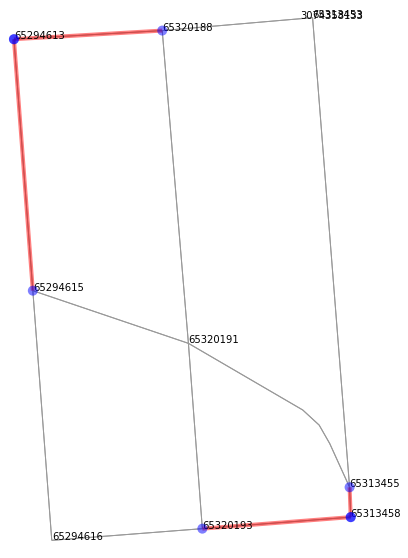

In [974]:
# TEST VISUALIZE double_back edges to test - clunky for now

print("Num edges with twice traversal:", len(twice_traversal_list))

routes = []

for edge in twice_traversal_list:    
    route = nx.shortest_path(G, edge[0], edge[1], weight='length')
    routes.append(route)

# MAKE GRAPH
fig, ax = ox.plot_graph_routes(G, 
                               routes,
                               route_color='r', 
                               orig_dest_node_color='b', 
                               node_size=0,
                               # axis_off=False,
                               annotate=True,
                               fig_height=10
                              )

In [1222]:
# # SCRAP -- YE OLDE VERSION --- CREATE A EULERIAN CIRCUIT 
# # def get_list_of_edges_by_traversal_count(edge_traversals_dict):
# #     """
# #     Given edge traversals dict, return a list of edges. 
# #     If the edge needs twice traversal it will appear twice in the 
# #     output list.

# #     """
    
# #     edges_list = []
    
# #     # look at each key (edge) in edge traversals dict
# #     for edge in edge_traversals_dict:
        
# #         # make var for number of traversals for current edge
# #         traversals = edge_traversals_dict[edge]
        
# #         # add the edge to the edges list as many times as it needs to be traversed
# #         for i in range(traversals):
        
# #             edges_list.append(edge)

# #     return edges_list


# def get_route_order(start_node_, edge_traversals_dict_, nodes_dict_):
    
#     node_order = []
#     edges_traversed = []

#     edges_list = get_list_of_edges_by_traversal_count(edge_traversals_dict_)
    
#     # print(edges_list)

#     start_node = start_node_
#     # print(len(nodes_dict_[start_node_]))
#     curr_node = start_node_ 
    
#     previous_node = None
    
#     # initialize temp graph
#     temp_G = nx.Graph()
    
#     while len(edges_list) > 0: # arbitrary while to start with

#         print("\n\n----------------\nNOW AT:", curr_node)
        
#         # get previous node 
#         if len(node_order) > 0:
#             previous_node = node_order[-1]
            
#         # print("previous_node:", previous_node)
#         node_order.append(curr_node)
#         # print("nodes_order:", node_order)
        
#         print("\nedges left on graph (current_edges_list):", edges_list)

#         print()
#         # figure out where to go next
#         # get all possible next nodes by looking at the connected edges

#         possible_next_edges_all = list(nodes_dict_[curr_node]) # make set into list to support indexing
        
        
#         # GET BRIDGES 
        
#         # clear out temp_graph's edges 
#         temp_G.clear()
        
#         # add all untraversed edges to graph 
#         # basically, you are considering edges already traversed as deleted 
#         # node: dupe edges will only be added once 
#         for edge in edges_list:
#             edge_node_1, edge_node_2 = edge
#             temp_G.add_edge(edge_node_1, edge_node_2)

#         # get all bridges in new graph
#         bridges_all = list(nx.bridges(temp_G))
        
#         # print("\nAll bridges without considering 2x trav:", bridges_all)
        
#         # remove all edges that have more than one traversal remaining
#         # from bridges list -- hacky way to acount for "parallel edges"
        
#         bridges_reduced = []
        
#         for possible_bridge in bridges_all:
            
#             possible_bridge_rev = possible_bridge[::-1]
            
#             if possible_bridge in edges_list:
#                 num_traverses_remaining = edges_list.count(possible_bridge)
                
#             elif possible_bridge_rev in edges_list:
#                 num_traverses_remaining = edges_list.count(possible_bridge_rev)
#             else: 
#                 num_traverses_remaining = 0
            
#             # if there is only one traverse left, it's a real bridge
#             if num_traverses_remaining < 2:
                
#                 bridges_reduced.append(possible_bridge)
        
#         print("\nAll bridges non 2x trav:", bridges_reduced)
        
#         possible_next_edges = []
        
#         possible_next_edges_bridges = []
        
#         # make a new possible next edge list, that does not include bridges
#         for edge in possible_next_edges_all:
#             if edge not in bridges_all:
#                 if edge[::-1] not in bridges_all:
#                     possible_next_edges.append(edge)
                    
#                 else:
#                     possible_next_edges_bridges.append(edge)
#             else:
#                     possible_next_edges_bridges.append(edge)
                    
#         # add bridges to the end of the pne list 
#         for edge in possible_next_edges_bridges:
            
#             possible_next_edges.append(edge)
                
        
#         print("\nPossible_next_edges (non_bridge, then bridge):", possible_next_edges_all)
        
#         # possible next edges non bridge = [possible_next_edges_all - bridges]
        
        
# #         pne_non_bridges = []
        
# #         for edge in possible_next_edges_all:
# #             if edge not in bridges_all:
# #                 pne_non_bridges.append(edge)
        
# #         possible_next_edges = pne_non_bridges + bridges_all
        
# #         print("\npossible next edges, nonB and B:", possible_next_edges)
        
# #         print("\npossible next edges PRE CLEAN:", possible_next_edges)
        
# #         # clean up possible next edges list 
# #             # remove edges without current node
        
# #         for edge in possible_next_edges:
# #             print(f"\n reviewing {edge}...")
            
# #             if curr_node not in edge:
# #                 print(f"\n {curr_node} is not in {edge}")
# #                 possible_next_edges.remove(edge)
# #             else:
# #                 print(f"\n {curr_node} is in {edge}")
        
# #         print("\npossible next edges:", possible_next_edges)

#         keep_looking = True
#         i = 0
        
#         # try all non-briges
#         while keep_looking == True:
#             # look through possible next edges for the current node 
#             # if the edge is able to be traversed (still in edges_list)
#             # make that edge the next edge_to_traverse and break out of loop
#             # otherwise, try the next edge

#             if possible_next_edges[i] in edges_list:

#                 edge_to_traverse = possible_next_edges[i]

#                 # remove the first instance of edge in list
#                 # (to account for edges that appear twice in list)
#                 edges_list.remove(edge_to_traverse)

#                 keep_looking = False


#             # check if the reversed ordered edge is in the list 
#             elif possible_next_edges[i][::-1] in edges_list:

#                 edge_to_traverse = possible_next_edges[i][::-1]

#                 # remove the first instance of edge in list
#                 # (to account for edges that appear twice in list)
#                 edges_list.remove(edge_to_traverse)

#                 keep_looking = False

#             else: 
#                 if len(edges_list) > 0:
#                     i = i + 1
#                 else:
#                     keep_looking = False


#         # make edge to traverse into list, so you can 
#         # remove the current node and get a one-item list
#         # then get that one item -- your next node

#         # print("\nnext edge chosen:", edge_to_traverse)
        
#         print("\ncurr_node:", curr_node)
#         print("\nedge_to_traverse:", edge_to_traverse)
        
#         edge_to_traverse_lst = list(edge_to_traverse) # make edge to traverse tuple into a list
        
#         edge_to_traverse_lst.remove(curr_node) # remove current node from edge to traverse list

#         next_node = (edge_to_traverse_lst)[0] # next node is the only node left in the edge to traverse list

#         edges_traversed.append(edge_to_traverse)
        
#         # print("edges_traversed:", edges_traversed)
        

#         # make the next node your new curr node, and start the loop over
#         curr_node = next_node
#         print("\next_node:", next_node)
    
#     # add start node to the end of the node order, then print the final order
#     node_order.append(start_node)
#     print("\n\nFINAL NODE ORDER:", node_order)
    
#     return node_order

In [1223]:
# odd_nodes = get_odd_nodes(G)

# nodes_dict = make_nodes_dict(G)

# possible_pairings_list = get_list_of_all_pairs_lists(odd_nodes)

# length_pairings_lists_dict = get_dict_length_pairings_lists(possible_pairings_list)

# optimal_pairing_list_dict = get_optimal_pairing_list_dict(length_pairings_lists_dict)

# twice_traversal_list = get_all_double_back_edges(optimal_pairing_list_dict)

# edge_traversals_dict_eulerian = make_traversal_dict_with_added_edges(twice_traversal_list, G) 

# # print("NODES DICT:", nodes_dict)
# # print()
# # print(edge_traversals_dict)

# #-----final_funciton----#
# # start_node = 65294616 # chose this from looking at the pic, should be randomized later or have user input 

# start_node = choice(list(nodes_dict.keys()))

# get_route_order(start_node, edge_traversals_dict, nodes_dict)


In [1174]:
# REFACTOR

current_node_for_test =  65313455
current_edges_list_for_test = [(65294613, 65294615), (65294613, 65294615), 
                               (65294615, 65320191), (65294615, 65294616), 
                               (65294616, 65320193), (65320191, 65320193), 
                               (65320193, 65313458), (65320193, 65313458), 
                               (65313453, 65313455), (65313453, 3074358133), 
                               (65313455, 65313458), (65313455, 65313458), 
                               (3074358133, 65320188)]

nodes_dict = nodes_dict = make_nodes_dict(G)

def get_bridges(edges_list):
    
    """
    
    Takes a list of edges, returns a list of all bridges in the graph.
    
    Note: bridges returned are true bridges, meaning that they are bridges
    calculated by networkx without the edges that have multiple traverses 
    remaining. 
    
    """
    
    # make a temporary graph 
    temp_G = nx.Graph()
    
    # add all current edges to the graph
    for edge in edges_list:
            edge_node_1, edge_node_2 = edge
            temp_G.add_edge(edge_node_1, edge_node_2)
    
    # get all_bridges in temp graph 
    bridges_all = list(nx.bridges(temp_G))
    
    # get set of edges with two traversals left (only want one of each, so use set)
    mult_trav_remaining = set([])
    
    for edge in edges_list:
        
        num_trav_remaining = edges_list.count(edge)
        
        if num_trav_remaining > 1:
            
            mult_trav_remaining.add(edge)
    
    mult_trav_remaining = list(mult_trav_remaining)
    
    # remove mult traversal edges from bridges list 
    
    # print("bridges_ all:", bridges_all)
    # print("\nmult_trav_remaining:", mult_trav_remaining)
    
    # make a new bridges list that contains only edges that don't have mult traversals left
    
    bridges_reduced = []
    
    for edge in bridges_all:
        # print("\n\nedge:", edge)
        print()
        if edge in mult_trav_remaining:
            print()
            # print(f"bridge {edge} is in {mult_trav_remaining}")
        elif edge[::-1] in mult_trav_remaining: 
            print()
            # print(f"bridge {edge} REVERSED is in {mult_trav_remaining}")
        else:
            # print(f"bridge {edge} is NOT in {mult_trav_remaining}")
            
            bridges_reduced.append(edge)
    
    # return a list of true bridges
    return bridges_reduced
    

    
bridges_on_current_graph = get_bridges(current_edges_list_for_test)  
    
print(bridges_on_current_graph)










[(65313453, 65313455), (65313453, 3074358133), (3074358133, 65320188)]


In [1179]:


def get_all_conn_edges_remaining_in_graph(current_node, remaining_edges, nodes_dict):
    
    """
    Takes current node, a list of remaining edges in graph, and a dictionary of nodes
    and their corresponding edges. 
    
    Returns a list of all edges connected to the input node that are still in the graph.
    
    """
    
    # print("\ncurrent_node:", current_node)
    # print("\nremaining_edges:", remaining_edges)

    
    # get list of all edges that contain the current node -- in the original graph
    all_conn_edges_in_original_graph = list(nodes_dict[current_node])
    
    # print(f"\nnodes_dict at {current_node}", all_conn_edges_in_original_graph)
    
    
    # remove duplicate edges from remaining edges by makeing a set, then making that set into a list
    
    remaining_edges_unique = list(set(remaining_edges))
    
    # loop remaining edges set
    # find edges that correspond to an edge in the nodes dict OR the reversed edge order is in the nodes dict
    
    possible_next_edges = []
    
    for remaining_edge in remaining_edges_unique:
        # print("\nremaining edge:", remaining_edge)
        
        # check if remaining edge is connected to current node:
        
        if current_node in remaining_edge:
            # print(f"{current_node} IS IN {remaining_edge}")
            
            possible_next_edges.append(remaining_edge)
        
        elif current_node not in remaining_edge:
            # print((f"{current_node} is NOT in {remaining_edge}"))
            pass
    
    # print("\n\npossible_next_edges:", possible_next_edges)
    
    return possible_next_edges
    
# know that the only next edge in nodes dict is (65320188, 3074358133), but is (3074358133, 65320188) in 
# remaining edges set 
# "true order" should be whats in the remaining edges set, because that's where we will need to remove the edges from
# once traversed 

# possible_next_edges_for_test = get_all_conn_edges_remaining_in_graph(current_node_for_test, current_edges_list_for_test, nodes_dict) 
    
# print("possible_next_edges_for_test", possible_next_edges_for_test)
    
    

In [1183]:
def choose_edge_to_traverse(current_node, possible_next_edges, current_bridges):
    """
    Takes in the current node, a list of possible next edges for node
    and a list of bridges on the graph.
    
    Returns the next 
    """
    # print("\ncurrent_node_for_test:", current_node)
    # print("\npossible_next_edges:", possible_next_edges)
    # print("\nbridges:",current_bridges )
    
    non_bridge_next_edges_options = []
    bridge_next_edge_options = []
    
    # find all possible next edges that are not in current bridges list 
    
    for possible_next_edge in possible_next_edges:
        
        # print(f"\n\nREVIEWING: {possible_next_edge}:")
        
        if possible_next_edge in current_bridges or possible_next_edge[::-1] in current_bridges:
            # print(f" {possible_next_edge} or {possible_next_edge[::-1]} in current_bridges")
            bridge_next_edge_options.append(possible_next_edge)
        else: 
            #print(f" {possible_next_edge} AND {possible_next_edge[::-1]} NOT in current_bridges")                               
            non_bridge_next_edges_options.append(possible_next_edge)
    
    # print("\n\nnon_bridge_next_edges_options:", non_bridge_next_edges_options)
    # print("bridge_next_edge_options:", bridge_next_edge_options)
    
    
    # if non_bridge_next_edges is not empty, return the first item in non_bridges 
    if len(non_bridge_next_edges_options) > 0:
        return non_bridge_next_edges_options[0]
    
    # if non_bridge_next_edges is empty, return the first item in bridges 
    else:
        return bridge_next_edge_options[0]
    

choose_edge_to_traverse(current_node_for_test, possible_next_edges_for_test, bridges_on_current_graph)



(65313455, 65313458)

In [1184]:
# get all edges in initial euler graph 

# KEEP THIS FUNCTION
def get_list_of_edges_by_traversal_count(edge_traversals_dict):
    """
    Given edge traversals dict, return a list of edges. 
    If the edge needs twice traversal it will appear twice in the 
    output list.

    """
    
    edges_list = []
    
    # look at each key (edge) in edge traversals dict
    for edge in edge_traversals_dict:
        
        # make var for number of traversals for current edge
        traversals = edge_traversals_dict[edge]
        
        # add the edge to the edges list as many times as it needs to be traversed
        for i in range(traversals):
        
            edges_list.append(edge)

    return edges_list

In [ ]:

# NOTE: G is the osmnx graph created from bbox:  
# G = ox.graph_from_bbox(north, south, east, west, network_type='walk')

def make_euler_circuit(start_node, graph):
    
    print("Start node:", start_node)
    
    # SET UP EULER GRAPH
    # get all odd nodes on graph 
    odd_nodes = get_odd_nodes(graph)
    
    # get all possible pairings for odd nodes in graph
    nodes_dict = make_nodes_dict(G)
    
    # get list of all possible pairings of odd nodes:
    possible_pairings_list = get_list_of_all_pairs_lists(odd_nodes)
    
    # get the length of each possible pairing of odd nodes 
    length_pairings_lists_dict = get_dict_length_pairings_lists(possible_pairings_list)
    
    # get the odd nodes pairing that has the shortest distance 
    optimal_pairing_list_dict = get_optimal_pairing_list_dict(length_pairings_lists_dict)
    
    # get list of edges that will need to be traversed twice 
    twice_traversal_list = get_all_double_back_edges(optimal_pairing_list_dict)
    
    # get dict of edges and how many times each needs to be traversed 
    edge_traversals_dict_eulerian = make_traversal_dict_with_added_edges(twice_traversal_list, graph) 
    
    # get list of all edges that need to be traversed, multiple traversal edges are included multiple times
    all_edges_in_euler_graph = get_list_of_edges_by_traversal_count(edge_traversals_dict_eulerian)

    # ---- # 
    
    # GET EULER CIRCUIT 
    
    # make list of edges currently on graph: 
    current_edges_on_graph_list = all_edges_in_euler_graph
    
    # initialize current node 
    current_node = start_node 
    
    # initialize a list the contains the order of node visists with the start node
    
    node_visit_order = [current_node]
    
    print("--------START-WALKING--------")
    
    while len(current_edges_on_graph_list) > 0:
        
        print("Node visit order:", node_visit_order)
        
        print("\n\nCURRENT NODE:", current_node)
        
        # print edges currently on the graph
        print("\nedges currently on graph:", current_edges_on_graph_list )

        # get the bridges on the initial graph
        current_bridges_on_graph = get_bridges(current_edges_on_graph_list)
        print("\nbridges currently on graph:", current_bridges_on_graph)

        # get all the connected edges in initial graph for the current node 
        edges_conn_to_current_node = get_all_conn_edges_remaining_in_graph(current_node, 
                                                                           current_edges_on_graph_list, 
                                                                           nodes_dict)
        print(f"\ncurrent node: {current_node} is still connected to: {edges_conn_to_current_node}")

        # get the next edge to traverse 
        edge_to_traverse = choose_edge_to_traverse(current_node, edges_conn_to_current_node, current_bridges_on_graph)
        print(f"\nedge_to_traverse:", edge_to_traverse)

        # remove edge just traversed from current_edges_on_graph_list
        ## you don't know the order of the nodes in the edge in the current_edges_on_graph_list,
        ## so you have to check both
        
        print("\nlen of current_edges_on_graph_list BEFORE removing one item:", len(current_edges_on_graph_list))
        
        if edge_to_traverse in current_edges_on_graph_list:
            current_edges_on_graph_list.remove(edge_to_traverse)
        else:
            current_edges_on_graph_list.remove(edge_to_traverse[::-1])
        print("\nlen of current_edges_on_graph_list AFTER removing one item:", len(current_edges_on_graph_list))
        
        # update current node to be node in edge_to_traverse that is not the current node
        ## make edge a list so that you can remove the current node
        
        print("\ncurrent node BEFORE update:", current_node)
        edge_to_traverse_list = list(edge_to_traverse)
        ## remove current node from edge to traverse
        edge_to_traverse_list.remove(current_node)
        ## update current node to be the only node left in the edge list
        
        current_node = edge_to_traverse_list[0]
        print("\ncurrent node AFTER update:", current_node)
        
        # add the new current node to the nodes visit order list 
        node_visit_order.append(current_node)
        
        print("\n\n\n----------WALKING-----------")

    return(node_visit_order)

In [ ]:
# call function with random start node

# start_node_test = choice(list(G.nodes))

# make_euler_circuit(start_node_test, G)

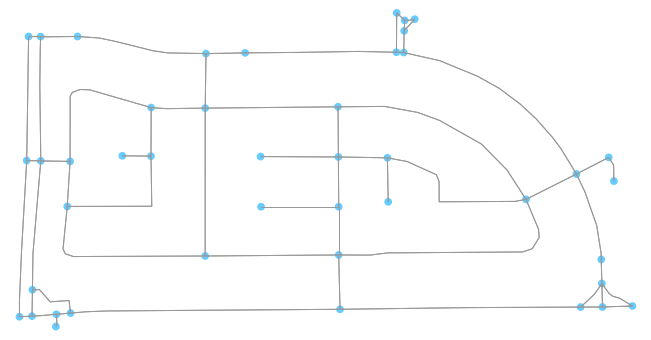


 n (number of nodes in the graph): 44

 m (number of edges in the graph): 59.0

 street_length_total (sum in meters): 3556.686999999999


In [1226]:
# TEST ON A DIFFERENT GRAPH 

# BUILD GRAPH & GET STATS

# set bbox bounds: (will eventually come from drawing)

north =  37.37095867427206 #  max lat 
south = 37.36621782045308  #  min lat
east = -122.00300216674805 #  max lng
west =  -122.01424598693846#  min lng 
 
# create graph
G = ox.graph_from_bbox(north, south, east, west, network_type='walk')

# display graph
ox.plot_graph(G, node_size=60)

# Get graph info 
basic_stats = ox.basic_stats(G)
    
print("\n n (number of nodes in the graph):", basic_stats['n'])
print("\n m (number of edges in the graph):", basic_stats['m']/2) # because it's an undirected graph
print("\n street_length_total (sum in meters):", basic_stats['street_length_total']/2)

In [1229]:
start_node_test = choice(list(G.nodes))

print(start_node_test)

# make_euler_circuit(start_node_test, G)

4136644678
